# MPV17
[Mitochondrial DNA depletion syndrome-6 (MTDPS6), also known as Navajo neurohepatopathy (NNH)](https://omim.org/entry/256810) is caused by homozygous or compound heterozygous mutation in the MPV17 gene .

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.9.1.dev0


In [2]:
gene_symbol = 'MPV17'
mane_tx_id = 'NM_002437.5'
mane_protein_id = 'NP_002428.1' 

In [3]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.22' 
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')
qc.summarize()

Individuals Processed: 100%|██████████| 60/60 [01:07<00:00,  1.13s/individuals]
Loaded 60 individuals
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
34,Hepatic failure
29,Increased circulating lactate concentration
25,Hypoglycemia
24,Hepatomegaly
23,Failure to thrive
21,Elevated circulating alanine aminotransferase concentration
21,Elevated circulating aspartate aminotransferase concentration
21,Hypotonia
19,Global developmental delay
16,Hepatic steatosis


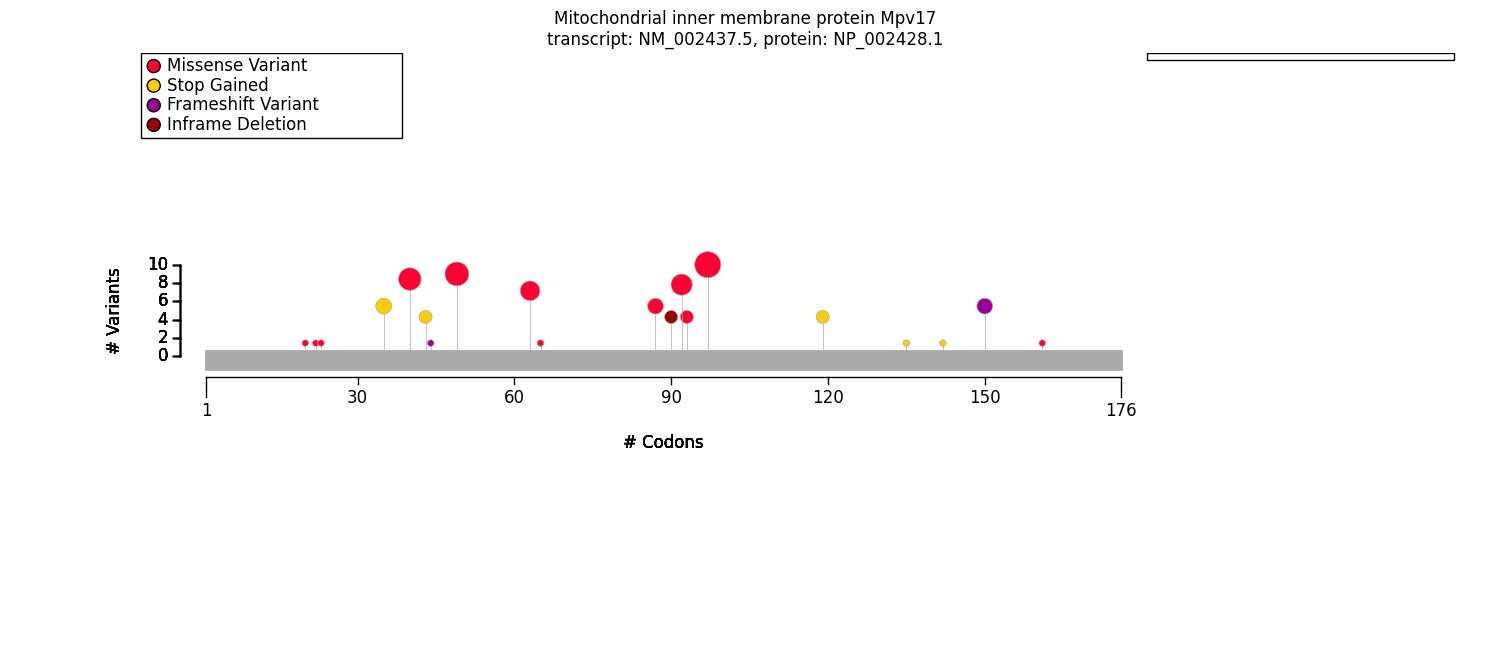

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

mpv17_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
mpv17_fig.tight_layout()

In [6]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
10,2_27312576_27312576_G_A,c.293C>T (p.Pro98Leu),5,missense
8,2_27313031_27313031_C_T,c.149G>A (p.Arg50Gln),3,missense
5,2_27312681_27312681_T_G,c.278A>C (p.Gln93Pro),4,"missense, splice region"
5,2_27312768_27312768_G_C,c.191C>G (p.Pro64Arg),4,missense
5,2_27313059_27313059_G_A,c.121C>T (p.Arg41Trp),3,missense
4,SO:1000029_HGNC:7224_MPV17,SV involving MPV17 (p.?),,chromosomal deletion
3,2_27311908_27311908_A_AG,c.451dup (p.Leu151ProfsTer39),7,frameshift
2,2_27312679_27312679_C_A,c.279+1G>T (-),-,splice donor
2,2_27313074_27313074_G_A,c.106C>T (p.Gln36Ter),3,stop gained
2,2_27311898_27311898_C_G,c.461+1G>C (-),-,splice donor


# Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_predicates = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import biallelic_classifier

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)


missense_predicate = biallelic_classifier(a_predicate=missense, 
                                   b_predicate=~missense, 
                                   a_label="missense",
                                   b_label="other",
                                    partitions=((0,1),(2,))
                                   )
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_predicate,
    pheno_clfs=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,42
HMF03,Skipping term because of a child term with the same individual counts,1
HMF08,Skipping general term,106
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,235


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense/missense OR missense/other  \
                                                                                 Count   
Global developmental delay [HP:0001263]                                           9/30   
Hypoglycemia [HP:0001943]                                                        13/29   
Failure to thrive [HP:0001508]                                                   11/24   
Hepatomegaly [HP:0002240]                                                        15/25   
Peripheral neuropathy [HP:0009830]                                               14/27   
Elevated circulating alanine aminotransferase c...                               11/14   
Elevated circulating aspartate aminotransferase...                               11/14   
Hepatic failure [HP:0001399]                                                     22/30   
Prolonged prothrombin time [HP:0008151]                                           6/17   
Jaundice [HP:0000952]                                                             6/13   
Abnormal prothrombin time [HP:0032199]                                            6/15   
Hypotonia [HP:0001252]                                                           17/26   
Abnormal liver morphology [HP:0410042]                                           30/30   
Decreased liver function [HP:0001410]                                            22/22   
Increased circulating lactate concentration [HP...                               18/25   
Acidosis [HP:0001941]                                                            21/21   
Abnormal blood glucose concentration [HP:0011015]                                13/13   
Cholestasis [HP:0001396]                                                         16/16   
Abnormality of the biliary system [HP:0004297]                                   17/17   
Abnormal muscle tone [HP:0003808]                                                17/17   
Visceromegaly [HP:0003271]                                                       15/15   
Hepatic steatosis [HP:0001397]                                                   14/19   
Vomiting [HP:0002013]                                                             7/16   

Allele group                                               other/other  \
                                                   Percent       Count   
Global developmental delay [HP:0001263]                30%       10/14   
Hypoglycemia [HP:0001943]                              45%       12/16   
Failure to thrive [HP:0001508]                         46%       12/16   
Hepatomegaly [HP:0002240]                              60%        9/10   
Peripheral neuropathy [HP:0009830]                     52%        2/10   
Elevated circulating alanine aminotransferase c...     79%       10/10   
Elevated circulating aspartate aminotransferase...     79%       10/10   
Hepatic failure [HP:0001399]                           73%       13/15   
Prolonged prothrombin time [HP:0008151]                35%        7/13   
Jaundice [HP:0000952]                                  46%        7/12   
Abnormal prothrombin time [HP:0032199]                 40%        7/13   
Hypotonia [HP:0001252]                                 65%       10/13   
Abnormal liver morphology [HP:0410042]                100%       14/14   
Decreased liver function [HP:0001410]                 100%       13/13   
Increased circulating lactate concentration [HP...     72%       11/15   
Acidosis [HP:0001941]                                 100%       12/12   
Abnormal blood glucose concentration [HP:0011015]     100%       12/12   
Cholestasis [HP:0001396]                              100%       11/11   
Abnormality of the biliary system [HP:0004297]        100%       11/11   
Abnormal muscle tone [HP:0003808]                     100%       10/10   
Visceromegaly [HP:0003271]                            100%         9/9   
Hepatic steatosis [HP:0001397]                 

In [11]:
from gpsea.analysis.predicate import variant_key

p98l = variant_key(key="2_27312576_27312576_G_A") # c.293C>T, p.Pro98Leu
p98l_predicate = biallelic_classifier(a_predicate=p98l, 
                                   b_predicate=~p98l, 
                                   a_label="Pro98Leu",
                                   b_label="other",
                                    partitions=((0,),(2,1))
                                   )
p98l_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=p98l_predicate,
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=p98l_result)


Allele group                                       Pro98Leu/Pro98Leu          \
                                                               Count Percent   
Peripheral axonal neuropathy [HP:0003477]                        3/3    100%   
Peripheral neuropathy [HP:0009830]                               3/3    100%   
Global developmental delay [HP:0001263]                          0/3      0%   
Failure to thrive [HP:0001508]                                   0/1      0%   
Abnormal prothrombin time [HP:0032199]                           1/1    100%   
Cirrhosis [HP:0001394]                                           1/2     50%   
Abnormal liver morphology [HP:0410042]                           2/2    100%   
Hepatic failure [HP:0001399]                                     2/2    100%   
Decreased liver function [HP:0001410]                            2/2    100%   
Increased circulating lactate concentration [HP...               1/1    100%   
Acidosis [HP:0001941]                                            2/2    100%   
Hypotonia [HP:0001252]                                           2/2    100%   
Abnormal muscle tone [HP:0003808]                                2/2    100%   
Elevated circulating alanine aminotransferase c...               1/1    100%   
Elevated circulating aspartate aminotransferase...               1/1    100%   
Hepatomegaly [HP:0002240]                                        2/3     67%   
Visceromegaly [HP:0003271]                                       2/2    100%   
Hepatic steatosis [HP:0001397]                                   1/1    100%   
Prolonged prothrombin time [HP:0008151]                          1/2     50%   

Allele group                                       other/other OR Pro98Leu/other  \
                                                                           Count   
Peripheral axonal neuropathy [HP:0003477]                                   1/22   
Peripheral neuropathy [HP:0009830]                                         13/34   
Global developmental delay [HP:0001263]                                    19/41   
Failure to thrive [HP:0001508]                                             23/39   
Abnormal prothrombin time [HP:0032199]                                     12/27   
Cirrhosis [HP:0001394]                                                     10/30   
Abnormal liver morphology [HP:0410042]                                     42/42   
Hepatic failure [HP:0001399]                                               33/43   
Decreased liver function [HP:0001410]                                      33/33   
Increased circulating lactate concentration [HP...                         28/39   
Acidosis [HP:0001941]                                                      31/31   
Hypotonia [HP:0001252]                                                     25/37   
Abnormal muscle tone [HP:0003808]                                          25/25   
Elevated circulating alanine aminotransferase c...                         20/23   
Elevated circulating aspartate aminotransferase...                         20/23   
Hepatomegaly [HP:0002240]                                                  22/32   
Visceromegaly [HP:0003271]                                                 22/22   
Hepatic steatosis [HP:0001397]                                             19/26   
Prolonged prothrombin time [HP:0008151]                                    12/28   

Allele group                                                                   \
                                                   Percent Corrected p values   
Peripheral axonal neuropathy [HP:0003477]               5%           0.033043   
Peripheral neuropathy [HP:0009830]                     38%           0.684685   
Global developmental delay [HP:0001263]                46%           1.000000   
Failure to thrive [HP:0001508]                         59%           1.000000   
Abnormal prothrombin time [HP:0032199]                 44%          

In [12]:
arg50gln = variant_key(key="2_27313031_27313031_C_T") # c.149G>A	p.Arg50Gln
arg50gln_predicate = biallelic_classifier(a_predicate=arg50gln, 
                                   b_predicate=~arg50gln, 
                                   a_label="Arg50Gln",
                                   b_label="other",
                                    partitions=((0,1),(2,))
                                   )
arg50gln_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=arg50gln_predicate,
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=arg50gln_result)

Allele group                                       Arg50Gln/Arg50Gln OR Arg50Gln/other  \
                                                                                 Count   
Cirrhosis [HP:0001394]                                                             6/8   
Hypotonia [HP:0001252]                                                             2/6   
Peripheral neuropathy [HP:0009830]                                                 5/6   
Global developmental delay [HP:0001263]                                            1/7   
Hepatomegaly [HP:0002240]                                                          3/7   
Prolonged prothrombin time [HP:0008151]                                            2/2   
Abnormal prothrombin time [HP:0032199]                                             2/2   
Increased circulating lactate concentration [HP...                                 0/1   
Hepatic failure [HP:0001399]                                                       6/6   
Elevated circulating alanine aminotransferase c...                                 4/5   
Elevated circulating aspartate aminotransferase...                                 4/5   
Hepatic steatosis [HP:0001397]                                                     4/4   
Abnormal liver morphology [HP:0410042]                                             8/8   
Decreased liver function [HP:0001410]                                              6/6   
Hypoglycemia [HP:0001943]                                                          4/8   
Abnormal blood glucose concentration [HP:0011015]                                  4/4   
Failure to thrive [HP:0001508]                                                     1/2   
Cholestasis [HP:0001396]                                                           4/4   
Abnormality of the biliary system [HP:0004297]                                     4/4   
Abnormal muscle tone [HP:0003808]                                                  2/2   
Visceromegaly [HP:0003271]                                                         3/3   

Allele group                                               other/other  \
                                                   Percent       Count   
Cirrhosis [HP:0001394]                                 75%        5/24   
Hypotonia [HP:0001252]                                 33%       25/33   
Peripheral neuropathy [HP:0009830]                     83%       11/31   
Global developmental delay [HP:0001263]                14%       18/37   
Hepatomegaly [HP:0002240]                              43%       21/28   
Prolonged prothrombin time [HP:0008151]               100%       11/28   
Abnormal prothrombin time [HP:0032199]                100%       11/26   
Increased circulating lactate concentration [HP...      0%       29/39   
Hepatic failure [HP:0001399]                          100%       29/39   
Elevated circulating alanine aminotransferase c...     80%       17/19   
Elevated circulating aspartate aminotransferase...     80%       17/19   
Hepatic steatosis [HP:0001397]                        100%       16/23   
Abnormal liver morphology [HP:0410042]                100%       36/36   
Decreased liver function [HP:0001410]                 100%       29/29   
Hypoglycemia [HP:0001943]                              50%       21/37   
Abnormal blood glucose concentration [HP:0011015]     100%       21/21   
Failure to thrive [HP:0001508]                         50%       22/38   
Cholestasis [HP:0001396]                              100%       23/23   
Abnormality of the biliary system [HP:0004297]        100%       24/24   
Abnormal muscle tone [HP:0003808]                     100%       25/25   
Visceromegaly [HP:0003271]                            100%       21/21   

Allele group                                                                   \
                                                   Percent Corrected p values   
Cirrhosis [HP:0001394]                                 21%      

In [13]:
from gpsea.analysis.clf import sex_classifier
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=sex_classifier(),
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

TypeError: MultiPhenotypeAnalysis.compare_genotype_vs_phenotypes() got an unexpected keyword argument 'gt_predicate'

In [32]:
from gpsea.analysis.temporal.endpoint import disease_onset, death
term_id = "HP:0003774"  # Stage 5 chronic kidney disease
endpoint = death()
from gpsea.analysis.temporal.stats import LogRankTest
survival_statistic = LogRankTest()
from gpsea.analysis.temporal import SurvivalAnalysis
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
p98l_mortality_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_predicate=p98l_predicate,
    endpoint=endpoint,
)
print(f"Survival analysis, Pro98Leu, p={p98l_mortality_result.pval:.4f}")

Survival analysis, Pro98Leu, p=0.0096


/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_45523/2535773842.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))


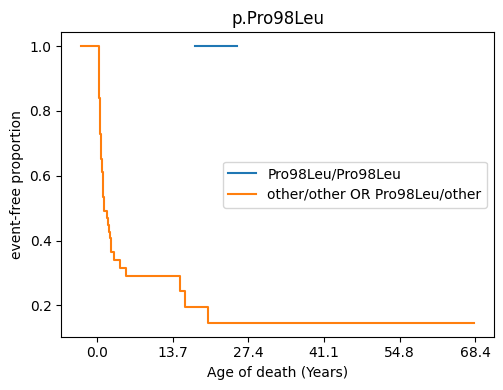

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
mpv17_fig, ax = plt.subplots(figsize=(6, 4))
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
def days_to_years(x, pos):
    return f"{x / 365.25:.1f}"


ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))

# Add labels
ax.set_xlabel("Age of death (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("p.Pro98Leu")

plt.tight_layout()
p98l_mortality_result.plot_kaplan_meier_curves(ax=ax)

In [15]:
from gpsea.analysis.temporal.endpoint import disease_onset, death
endpoint = disease_onset(disease_id="OMIM:256810")
from gpsea.analysis.temporal.stats import LogRankTest
survival_statistic = LogRankTest()
from gpsea.analysis.temporal import SurvivalAnalysis
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
missense_mortality_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_predicate,
    endpoint=endpoint,
)
print(f"Survival analysis, Missense, onset, p={missense_mortality_result.pval:.4f}")

Survival analysis, Missense, onset, p=0.0019


/var/folders/89/kbwcd2bd00vfsgf732nbfd3j169gjj/T/ipykernel_46759/1620576432.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))


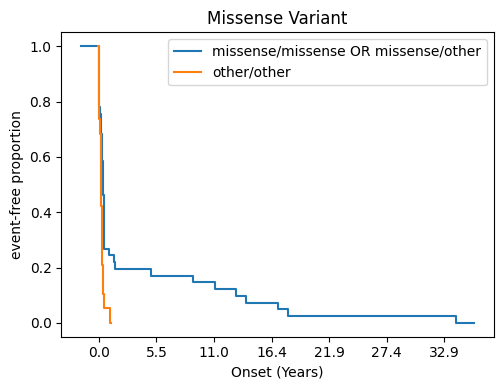

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
_, ax = plt.subplots(figsize=(6, 4))
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
def days_to_years(x, pos):
    return f"{x / 365.25:.1f}"


ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))

# Add labels
ax.set_xlabel("Onset (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Missense Variant")

plt.tight_layout()
missense_mortality_result.plot_kaplan_meier_curves(ax=ax)

# Summary

In [ ]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


f_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=p98l_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=arg50gln_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    )
)

M_results = (
    GPAnalysisResultSummary.from_mono(
        result=p98l_mortality_result,

    ),
    GPAnalysisResultSummary.from_mono(
        result=missense_mortality_result,

    )
)


report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             mono_results=M_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id)

In [37]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [38]:
summarizer.process_latex(report=report, protein_fig=mpv17_fig)

Figure saved to ../../supplement/img/MPV17_protein_diagram-draft.pdf
Output to ../../supplement/tex/MPV17_summary_draft.tex
